
[![寒假工作坊](img/workshop.png)](https://hidadeng.github.io/blog/2022workshop/)


## tomotopy简介？
tomotopy 是 tomoto（主题建模工具）的 Python 扩展，它是用 C++ 编写的基于 Gibbs 采样的主题模型库。支持的主题模型包括 LDA、DMR、HDP、MG-LDA、PA 和 HPA， 利用现代 CPU 的矢量化来最大化速度。 

https://github.com/bab2min/tomotopy

**下图中同样的数据集， tomotopy迭代200次，gensim迭代10次的情况下， tomotopy与gensim耗时对比图，由此可见tomotopy训练主题模型速度之快。**
![](TomotopyVsGensim.png)

当前版本的 tomotopy 支持的主题模型包括
- 潜在狄利克雷分配（LDAModel）
- 标记的 LDA（LLDA 模型）
- 部分标记的 LDA（PLDA 模型）
- 监督LDA（SLDA模型）
- Dirichlet 多项回归 (DMRModel)
- 广义狄利克雷多项回归 (GDMRModel)
- 分层狄利克雷过程 (HDPModel)
- 分层LDA（HLDA模型）
- 多粒 LDA（MGLDA 模型）
- 弹珠盘分配（PAModel）
- 分层 PA (HPAModel)
- 相关主题模型（CTModel）
- 动态主题模型 (DTModel)
- 基于伪文档的主题模型（PTModel）。

<br>

## 安装

In [ ]:
!pip3 install tomotopy==0.12.2
!pip3 install pyLDAvis==3.3.1  

目前，tomotopy 可以利用 AVX2、AVX 或 SSE2 SIMD 指令集来最大程度利用PC的性能。 

In [1]:
import tomotopy as tp

tp.isa

'avx2'

如果 tp.isa 返回 None，则训练过程可能需要很长时间。 

<br>

## 1. 导入数据
准备一个自己很熟悉的数据disaster_news.csv，一共有332条，话题数K=5，（正常情况下K是需要探索的）。

In [2]:
import pandas as pd

df = pd.read_csv('disaster_news.csv')
df.head()

text
0  云南永善县级地震已致人伤间民房受损中新网月日电据云南昭通市防震减灾局官方网站消息截至日时云南...
1  四川蓬安县房屋瓦片被震落广西陕西震感强烈年月日月日时分四川汶川发生级地震时分新民网记者电话连...
2  四川汶川强地震近万人丧生中国各界奋力救灾中新社北京五月十三日电综合消息截至北京时间十时北京时...
3  四川发生级地震波及云南多个地区年月日中新社昆明月三十日电八记者甘娜刘子倩八月三十日十六时三十...
4  四川攀枝花地震已部分房屋垮塌年月日新华网成都月日电记者肖林杨三军记者从攀枝花仁和区和凉山彝族...

<br>

## 2. 整理数据
分词、去除停用词

In [3]:
import re
import jieba
from cntext import STOPWORDS_zh


def segment(text):
    words = jieba.lcut(text)
    words = [w for w in words if w not in STOPWORDS_zh]
    return words

test = "云南永善县级地震已致人伤间民房受损中新网月日电据云南昭通市防震减灾局官方网站消息截至日时云南昭通永善县级地震已造成人受伤其中重伤人轻伤人已全部送医院救治民房受损户间倒塌户间个乡镇所学校不同程度受损目前被损毁电力交通通讯设施已全部抢通修复当地已调拨帐篷顶紧急转移万人月日时分云南昭通永善县发生里氏级地震震源深度公里当地震感强烈此外成都等四川多地也有明显震感"
print(segment(test))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/sc/3mnt5tgs419_hk7s16gq61p80000gn/T/jieba.cache
Loading model cost 0.539 seconds.
Prefix dict has been built successfully.


['云南', '永善县', '级', '地震', '已致', '伤间', '民房', '受损', '中新网', '日电', '云南', '昭通市', '防震', '减灾', '局', '官方网站', '消息', '日时', '云南', '昭通', '永善县', '级', '地震', '造成', '受伤', '重伤', '轻伤', '送', '医院', '救治', '民房', '受损', '户间', '倒塌', '户间', '乡镇', '学校', '不同', '程度', '受损', '目前', '损毁', '电力', '交通', '通讯', '设施', '抢通', '修复', '调拨', '帐篷', '顶', '紧急', '转移', '万人', '时分', '云南', '昭通', '永善县', '发生', '里氏', '级', '地震', '震源', '深度', '公里', '震感', '强烈', '成都', '四川', '多地', '明显', '震感']


In [4]:
df['words'] = df['text'].apply(segment)
df.head()

text  \
0  云南永善县级地震已致人伤间民房受损中新网月日电据云南昭通市防震减灾局官方网站消息截至日时云南...   
1  四川蓬安县房屋瓦片被震落广西陕西震感强烈年月日月日时分四川汶川发生级地震时分新民网记者电话连...   
2  四川汶川强地震近万人丧生中国各界奋力救灾中新社北京五月十三日电综合消息截至北京时间十时北京时...   
3  四川发生级地震波及云南多个地区年月日中新社昆明月三十日电八记者甘娜刘子倩八月三十日十六时三十...   
4  四川攀枝花地震已部分房屋垮塌年月日新华网成都月日电记者肖林杨三军记者从攀枝花仁和区和凉山彝族...   

                                               words  
0  [云南, 永善县, 级, 地震, 已致, 伤间, 民房, 受损, 中新网, 日电, 云南, ...  
1  [四川, 蓬安县, 房屋, 瓦片, 震落, 广西, 陕西, 震感, 强烈, 年月日, 时分,...  
2  [四川, 汶川, 强, 地震, 近万人, 丧生, 中国, 各界, 奋力, 救灾, 中新社, ...  
3  [四川, 发生, 级, 地震波, 云南, 多个, 地区, 年月日, 中新社, 昆明, 三十日...  
4  [四川, 攀枝花, 地震, 部分, 房屋, 垮塌, 年月日, 新华网, 成都, 日电, 记者...



<br>

## 3. 找到最佳K
正常的步骤应该认真对待这步，在一定区间范围内，根据模型得分找到合理的K。这里使用tomotopy提供的主题一致性coherence得分假装找一下。

我们期望的图应该的topic coherence随着 number of topics增加而增加，然后到某个topic值趋于平稳。


tomotopy每次运行得到的图形状不一样，为了保证运行结果具有可比性，设置了随机种子seed为555，你也可以根据需要改为自己需要的随机状态(这里有点像炼丹)。经过运行发现k=5比较合适（跑出了我的预判）。

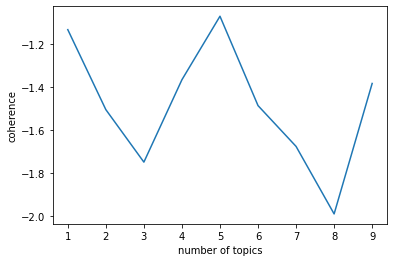

In [5]:
def find_k(docs, min_k=1, max_k=20, min_df=2):
    #min_df 词语最少出现在2个文档中
    import matplotlib.pyplot as plt
    scores = []
    for k in range(min_k, max_k):
        #seed随机种子，保证在大邓这里运行结果与你运行的结果一样
        mdl = tp.LDAModel(min_df=min_df, k=k, seed=555)
        for words in docs:
            if words:
                mdl.add_doc(words)
        mdl.train(20)
        coh = tp.coherence.Coherence(mdl)
        scores.append(coh.get_score())

    #x = list(range(min_k, max_k - 1))  # 区间最右侧的值。注意：不能大于max_k
    #print(x)
    #print()
    plt.plot(range(min_k, max_k), scores)
    plt.xlabel("number of topics")
    plt.ylabel("coherence")
    plt.show()
    
    
find_k(docs=df['words'], min_k=1, max_k=10, min_df=2)

<br>

## 4. 训练lda
使用tomotopy的LDA模型， 话题数K=5

In [6]:
import tomotopy as tp

#初始化LDA
mdl = tp.LDAModel(k=5, min_df=2, seed=555)
for words in df['words']:
    #确认words 是 非空词语列表
    if words:
        mdl.add_doc(words=words)

#训练
mdl.train()

#查看每个topic feature words
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))
    print('\n')

Top 10 words of topic #0
[('一辆', 0.02751251682639122), ('事故', 0.021704642102122307), ('记者', 0.018342189490795135), ('死亡', 0.01650812290608883), ('造成', 0.014062701724469662), ('人员', 0.013909862376749516), ('现场', 0.013451346196234226), ('受伤', 0.012687151320278645), ('相撞', 0.011922957375645638), ('货车', 0.011922957375645638)]


Top 10 words of topic #1
[('学生', 0.02709135226905346), ('食物中毒', 0.02498047426342964), ('出现', 0.019175563007593155), ('医院', 0.016185153275728226), ('事件', 0.013546556234359741), ('调查', 0.013194743543863297), ('年月日', 0.012842929922044277), ('治疗', 0.012667023576796055), ('症状', 0.011787491850554943), ('名', 0.011259771883487701)]


Top 10 words of topic #2
[('现场', 0.018848909065127373), ('发生', 0.01677251048386097), ('医院', 0.015015557408332825), ('起火', 0.014216942712664604), ('原因', 0.012140544131398201), ('目前', 0.012140544131398201), ('救治', 0.01150165218859911), ('进行', 0.011022482998669147), ('名', 0.009425252676010132), ('火势', 0.009265529923141003)]


Top 10 words of topic

In [7]:
#查看话题模型信息
mdl.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 332 docs, 29749 words
| Total Vocabs: 8428, Used Vocabs: 2984
| Entropy of words: 7.10665
| Entropy of term-weighted words: 7.10665
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 10, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.79934
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 2 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 5 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 555 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.7143365  0.6852513

### topic解读
根据每个话题top10的特征词，5个话题解读为


- 交通事故| #0 (6513) : 一辆 事故 记者 死亡 造成
- 食品安全| #1 (5655) : 学生 食物中毒 出现 医院 事件
- 火灾新闻| #2 (6231) : 现场 发生 医院 起火 原因
- 恐怖袭击| #3 (5107) : 发生 爆炸 造成 死亡 受伤
- 地震灾害| #4 (6243) : 地震 发生 火灾 时分 级


<br>

## 5. 可视化
使用pyLDAvis   

In [8]:
import pyLDAvis
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=Warning)

#在notebook显示
pyLDAvis.enable_notebook()

#获取pyldavis需要的参数
topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy话题id从0开始，pyLDAvis话题id从1开始
    sort_topics=False #注意：否则pyLDAvis与tomotopy内的话题无法一一对应。 
)


#可视化结果存到html文件中
#pyLDAvis.save_html(prepared_data, 'ldavis.html')

#notebook中显示
pyLDAvis.display(prepared_data)

/Library/Frameworks/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/anaconda3/lib/python3.9/site-packages/past/b

![](ldavis.png)

<br>

## 6. 预测
预测某文档的话题

In [9]:
import jieba
from cntext import STOPWORDS_zh

#预测
doc = '云南永善县级地震已致伤间民房受损中新网日电云南昭通市防震减灾局官方网站消息日时云南昭通永善县级地震造成受伤重伤轻伤送医院救治民房受损户间倒塌户间乡镇学校不同程度受损目前损毁电力交通通讯设施抢通修复调拨帐篷顶紧急转移万人时分云南昭通永善县发生里氏级地震震源深度公里震感强烈成都四川多地明显震感'
words = [w for w in jieba.lcut(doc) if w not in STOPWORDS_zh]

#构造tomotopy需要的数据
doc_inst = mdl.make_doc(words=words)
topic_dist, ll = mdl.infer(doc_inst)
print("Topic Distribution for Unseen Docs: ", topic_dist)


Topic Distribution for Unseen Docs:  [0.06785662 0.09622534 0.12595756 0.2536233  0.45633724]


列表长度为5， 列表第三个数值(topic #2)数值最大，该文本最大的可能性是topic #2


<br>

## 补充: 指定主题特征词
如果对数据比较了解，已经知道有一些主题，可以把比较明显的词语分配给指定的topic_id。

In [10]:
mdl = tp.LDAModel(k=5, min_df=2, seed=555)

for words in df['words']:
    if words:
        mdl.add_doc(words)

#把word相撞 分配给topic_0, 权重设置为1， 其他topic权重设置为0.1
#注意这里的range(5) 5是对应的k值
mdl.set_word_prior('相撞', [1.0 if k == 0 else 0.1 for k in range(5)])
#把word地震 分配给topic_1, 权重设置为1， 其他topic权重设置为0.1
mdl.set_word_prior('地震', [1.0 if k == 1 else 0.1 for k in range(5)])
#把word火灾 分配给topic_2, 权重设置为1， 其他topic权重设置为0.1
mdl.set_word_prior('火灾', [1.0 if k == 2 else 0.1 for k in range(5)])
#把word中毒 分配给topic_3, 权重设置为1， 其他topic权重设置为0.1
mdl.set_word_prior('中毒', [1.0 if k == 3 else 0.1 for k in range(5)])
#把word袭击 分配给topic_4, 权重设置为1， 其他topic权重设置为0.1
mdl.set_word_prior('袭击', [1.0 if k == 4 else 0.1 for k in range(5)])

mdl.train()
mdl.summary()  

<Basic Info>
| LDAModel (current version: 0.12.2)
| 332 docs, 29749 words
| Total Vocabs: 8428, Used Vocabs: 2984
| Entropy of words: 7.10665
| Entropy of term-weighted words: 7.10665
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 10, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.72251
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 2 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 5 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 555 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.7106193  0.6026444